Using [Ocean Parcels](https://oceanparcels.org) to determine the surface movement of a point pollution oil spill.
Original code written by Bec Gordon & Javier Porobic, CSIRO. Code requires additional python libraries stored in /Parcel_Utils/ within the [SSAM Ocean Parcels Repo](https://bitbucket.csiro.au/users/por07g/repos/ssam_oceanparcels/browse)

In [1]:
import sys
import os
import math
import xarray as xr
import matplotlib.pyplot as plt
from pathlib import Path
from pprint import pprint
from parcels import VectorField, Variable, AdvectionRK4, ErrorCode
from parcels import FieldSet, plotTrajectoriesFile, Variable, ScipyParticle, Field, ParcelsRandom
import numpy as np
from datetime import timedelta
sys.path.append('/ocean/rlovindeer/Atlantis/ssam_oceanparcels/Parcels_Utils/particle_tracking/parcels/')
from util.seed_particles import get_particles, get_release_times
# from util.parse_wildcards import parse_wildcards

INFO: Compiled ParcelsRandom ==> /tmp/parcels-2926/libparcels_random_3652ccb3-94d3-40a0-b4dc-149b82bd19d2.so


| **spill ID**  | **oil** | **spill size (m^3)** | **season** | **location** |
|---------|---------|--------------------|------------|--------------|
| 4a | Diesel | 500 | summer, ebb tide | Active Pass |
| 5b | Dilbit | 2000 | winter, ebb tide | Turn Point, Arachne Reef |
| 6a | Bunker C| 15 | summer, flood tide | leaving Vancouver Harbour, at Anchorage|
| 7a | Bunker C| 1000 | winter storm, flood tide | Strait of Juan de Fuca |


In [2]:
# Spill release times (years 2019 and 2020 only)
release_start_time = '2019-07-03' 
release_end_time = '2019-07-04'
release_YYYY = '2019-07'

Select the location of interest, which is specified by a shapefile.

In [3]:
scenario = "5b_TurnPoint_Dilbit"

In [4]:
#Kernels
def WindAdvectionRK4(particle, fieldset, time):
    """Advection of particles using fourth-order Runge-Kutta integration.
     Function needs to be converted to Kernel object before execution"""
    if particle.beached == 0:
        wp = fieldset.wind_percentage ## this need to be add to the fieldset
        
        if wp > 0:

            (u1, v1) = fieldset.UVwind[time, particle.depth, particle.lat, particle.lon]
            u1 = u1 * wp
            v1 = v1 * wp
            lon1, lat1 = (particle.lon + u1*.5*particle.dt, particle.lat + v1*.5*particle.dt)
            
            (u2, v2) = fieldset.UVwind[time + .5 * particle.dt, particle.depth, lat1, lon1]
            u2 = u2 * wp
            v2 = v2 * wp
            lon2, lat2 = (particle.lon + u2*.5*particle.dt, particle.lat + v2*.5*particle.dt)
            
            (u3, v3) = fieldset.UVwind[time + .5 * particle.dt, particle.depth, lat2, lon2]
            u3 = u3 * wp
            v3 = v3 * wp
            lon3, lat3 = (particle.lon + u3*particle.dt, particle.lat + v3*particle.dt)
            
            (u4, v4) = fieldset.UVwind[time + particle.dt, particle.depth, lat3, lon3]
            u4 = u4 * wp
            v4 = v4 * wp            
            
            u_wind  = (u1 + 2*u2 + 2*u3 + u4) / 6. * particle.dt
            v_wind  = (v1 + 2*v2 + 2*v3 + v4) / 6. * particle.dt
            
            particle.lon += (u1 + 2*u2 + 2*u3 + u4) / 6. * particle.dt
            particle.lat += (v1 + 2*v2 + 2*v3 + v4) / 6. * particle.dt
            
            particle.beached = 2
            
def beaching(particle, fieldset, time):
    
    if particle.beached == 2:
        
        # Parameters
        deg2m = 111000     # [m/deg]
        D = 50   # maximum beaching distance [m]
        
        # Grounding probability over radius D
        offset_lon = random.uniform(-1., 1.) * D / deg2m
        offset_lat = random.uniform(-1., 1.) * D / deg2m

        # Evaluate if chosen point is over land
        (u, v) = fieldset.UV[time, particle.depth, particle.lat + offset_lat, particle.lon + offset_lon]
        if u == 0 and v == 0: 
            particle.beached = 1
        else:
            particle.beached = 0

def DeleteParticle(particle, fieldset, time):
    """Delete particle from OceanParcels simulation to avoid run failure
    """

    print(f'Particle {particle.id} lost !! [{particle.time}, {particle.depth}, {particle.lat}, {particle.lon}]')
    particle.delete()

def DecayParticle(particle, fieldset, time):
    dt = particle.dt
    field_decay_value = fieldset.decay
    decay = math.exp(0 * dt/field_decay_value) # -0.099 for diesel, 0 for other oils
    particle.decay_value = particle.decay_value * decay

In [5]:
# Data Paths
currents = Path('/ocean/rlovindeer/Atlantis/Physics/Raw_Transport_Data/')
winds = Path('/ocean/rlovindeer/Atlantis/Physics/Wind/')
sea_grid = Path('/ocean/rlovindeer/Atlantis/Physics/Grids/ubcSSnBathymetryV17-02_a29d_efc9_4047.nc')
air_grid = Path('/ocean/rlovindeer/Atlantis/Physics/Grids/ubcSSaAtmosphereGridV1_0f03_6268_df4b.nc')

In [6]:
# Salish Sea NEMO Model Grid, Geo-location and Bathymetry, v17-02

# Currents
# u_data_path = currents + '2018-01*URaw_variables.nc'
# v_data_path = currents + '2018-01*VRaw_variables.nc'
# u_current = parse_wildcards(u_data_path, 'u')
# v_current = parse_wildcards(v_data_path, 'v')

u_current = sorted([p for p in currents.glob(str(release_YYYY) + '*URaw_variables.nc')])
v_current = sorted([p for p in currents.glob(str(release_YYYY) + '*VRaw_variables.nc')])

filenames = {
    'U': {'lon': sea_grid,'lat': sea_grid,'data': u_current},
    'V': {'lon': sea_grid,'lat': sea_grid,'data': v_current}
            }

variables = {'U': 'uVelocity','V': 'vVelocity'}
dimensions = {'lon': 'longitude', 'lat': 'latitude', 'time': 'time'}
print('creating from_nemo')
fieldset = FieldSet.from_nemo(filenames, variables, dimensions, allow_time_extrapolation=True)
print('creating from_nemo done')

fieldset.add_constant('decay', 1.0 * 3600.0)
print('add_constant decay')

creating from_nemo


creating from_nemo done
add_constant decay


In [7]:
# HRDPS, Salish Sea, Atmospheric Forcing Grid, Geo-location, v1"

wind_paths = sorted([p for p in winds.glob(str(release_YYYY) + '*Wind_variables.nc')])
wind_filenames = {'lon': os.fspath(air_grid),'lat': os.fspath(air_grid),'data': wind_paths}
wind_dimensions = {'lon': 'longitude', 'lat': 'latitude', 'time': 'time'}

pprint(wind_filenames)

{'data': [PosixPath('/ocean/rlovindeer/Atlantis/Physics/Wind/2019-07-06_Wind_variables.nc'),
          PosixPath('/ocean/rlovindeer/Atlantis/Physics/Wind/2019-07-12_Wind_variables.nc'),
          PosixPath('/ocean/rlovindeer/Atlantis/Physics/Wind/2019-07-18_Wind_variables.nc'),
          PosixPath('/ocean/rlovindeer/Atlantis/Physics/Wind/2019-07-24_Wind_variables.nc'),
          PosixPath('/ocean/rlovindeer/Atlantis/Physics/Wind/2019-07-30_Wind_variables.nc')],
 'lat': '/ocean/rlovindeer/Atlantis/Physics/Grids/ubcSSaAtmosphereGridV1_0f03_6268_df4b.nc',
 'lon': '/ocean/rlovindeer/Atlantis/Physics/Grids/ubcSSaAtmosphereGridV1_0f03_6268_df4b.nc'}


In [8]:
Uwind_field = Field.from_netcdf(wind_filenames, ('U_wind', 'u_wind'),
                                     wind_dimensions,
                                     fieldtype='U',
                                     allow_time_extrapolation=True,
                                     transpose=False,
                                     deferred_load=False)
Vwind_field = Field.from_netcdf(wind_filenames, ('V_wind', 'v_wind'),
                                     wind_dimensions,
                                     fieldtype='V',
                                     allow_time_extrapolation=True,
                                     transpose=False,
                                     deferred_load=False)

print('wind data loaded')

wind data loaded


In [9]:
# change longitude for the wind field
Uwind_field.grid.lon = Uwind_field.grid.lon - 360
Vwind_field.grid.lon = Vwind_field.grid.lon - 360

[x_min, x_max, y_min, y_max] = Uwind_field.grid.lonlat_minmax

Uwind_field.grid.lonlat_minmax = [x_min - 360, x_max - 360, y_min, y_max]
Vwind_field.grid.lonlat_minmax = [x_min - 360, x_max - 360, y_min, y_max]

## adding the wind field to the fieldset object
fieldset.add_field(Uwind_field)
fieldset.add_field(Vwind_field)
wind_field = VectorField('UVwind', Uwind_field,  Vwind_field)
fieldset.add_vector_field(wind_field)

In [10]:
# wind_percentage
# We need to do a sensitivity analysis of the percetage of wind to be used here
wind_percentage = 3
fieldset.add_constant('wind_percentage', wind_percentage/100.0)

In [ ]:
class MyParticle(ScipyParticle):
    initial_time = -100
    decay_value = Variable('decay_value', dtype=np.float32, initial=1.0)
    beached = Variable('beached', dtype=np.int32, initial=0.)
    age = Variable('age', dtype=np.int32, initial=0.)

# Particle Features
num_particles_per_day = 10000
feature_release_index = 0
input_shapefile_name = "/ocean/rlovindeer/Atlantis/ssam_oceanparcels/SalishSea/Shape_Scenarios/" + scenario + ".shp"
release_depth = -0.1
release_start_time = np.datetime64(release_start_time)
release_end_time = np.datetime64(release_end_time)
time_origin = fieldset.U.grid.time_origin.time_origin

print('setting up particles')

[release_times, p, num_particles] = get_release_times(time_origin, num_particles_per_day, release_start_time, release_end_time)
pset = get_particles(fieldset, num_particles, input_shapefile_name, MyParticle, feature_release_index, release_times, release_depth)

#print(pset)

# Building the kernels
decay_kernel = pset.Kernel(DecayParticle)
beaching_kernel = pset.Kernel(beaching)
ForcingWind_kernel = pset.Kernel(WindAdvectionRK4)

# Adding to the main kernel
my_kernel =  AdvectionRK4 + decay_kernel + ForcingWind_kernel + beaching_kernel

output_file_name = scenario + '_' + str(release_start_time) +  '_10000_OP_D50_wp3.nc'
print(output_file_name)

In [12]:
try:
    os.system('rm ' + output_file_name)
except:
    pass

print('executing particle kernel')

executing particle kernel


rm: cannot remove '5b_TurnPoint_Dilbit_2019-07-03_10000_OP_D50_wp3.nc': No such file or directory


In [ ]:
## Output properties
output_file = pset.ParticleFile(name= output_file_name, outputdt = timedelta(minutes = 60))
pset.execute(my_kernel,                 # the kernel (which defines how particles move)
             runtime=timedelta(hours = 24*7),   # the total length of the run
             dt = timedelta(minutes = 60),      # the timestep of the kernel
             output_file = output_file,          # the file name and the time step of the outputs
             recovery={ErrorCode.ErrorOutOfBounds: DeleteParticle})  # 
output_file.close()

plotTrajectoriesFile(output_file_name);

print('particle trajectories completed')

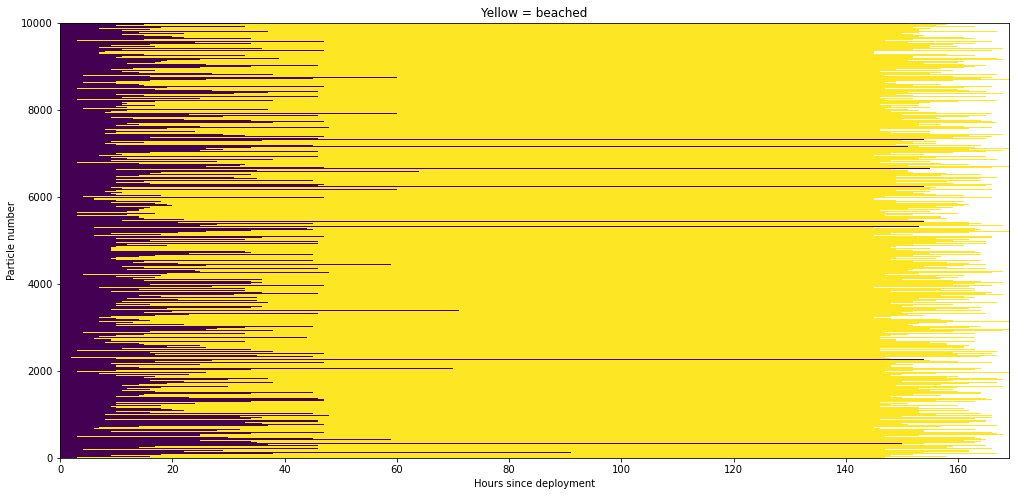

In [2]:
pfile = xr.open_dataset('5b_TurnPoint_Dilbit_2019-07-03_10000_OP_D50_wp3.nc', decode_cf=True)
fig, ax = plt.subplots(figsize=(17, 8))
ax.pcolormesh(pfile.beached)
ax.set_xlabel('Hours since deployment')
ax.set_ylabel('Particle number')
ax.set_title('Yellow = beached')
plt.show()